In [77]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math
from scipy.interpolate import interp1d

In [78]:
# read csv file from a game
df = pd.read_csv("2023_03_21_GW_Maryland.csv")
# sort data by the time of the pitch thrown, ascending
df = df.sort_values('Time')
# 0.01145833 miles is 60ft 6in
df['TimeToPlate'] = df['RelSpeed'].apply(lambda x: 0.01145833 / x * 3600)
#0.003882576 miles is 20ft 6in , needed because pfxx, pfxz are measure 40ft from plate
# df['TimeTopf'] = df['RelSpeed'].apply(lambda x: 0.003882576 / x * 3600)
#0.001988636 miles is 10ft 6in , needed because x0, z0 are measure 50ft from plate
df['TimeTo0'] = df['RelSpeed'].apply(lambda x: 0.001988636 / x * 3600)

In [79]:
pitcher = 'David Falco'
pitcher_df = df.loc[df['Pitcher'] == pitcher]
pitch_dfs = pitcher_df.groupby('TaggedPitchType')
pitch_data = {}
for pitch in pitch_dfs:
    # pitch_data[pitch[0]] = [pitch[1]['InducedVertBreak'].mean(), pitch[1]['pfxz'].mean(), pitch[1]['HorzBreak'].mean(), pitch[1]['pfxx'].mean(), pitch[1]['TimeToPlate'].mean(), pitch[1]['TimeTopf'].mean()]
    startSide = pitch[1]['RelSide'].mean() * 12
    startHeight = pitch[1]['RelHeight'].mean() * 12
    midSide  = -pitch[1]['x0'].mean() * 12
    midHeight = pitch[1]['z0'].mean() * 12
    endSide = pitch[1]['PlateLocSide'].mean() * 12
    endHeight = pitch[1]['PlateLocHeight'].mean() * 12
    pitch_data[pitch[0]] = [endHeight-startHeight, midHeight-startHeight, abs(endSide-startSide), abs(midSide-startSide), pitch[1]['TimeToPlate'].mean(), pitch[1]['TimeTo0'].mean()]

Now I can create a graph that compares each pitch's movement to see any synergy.

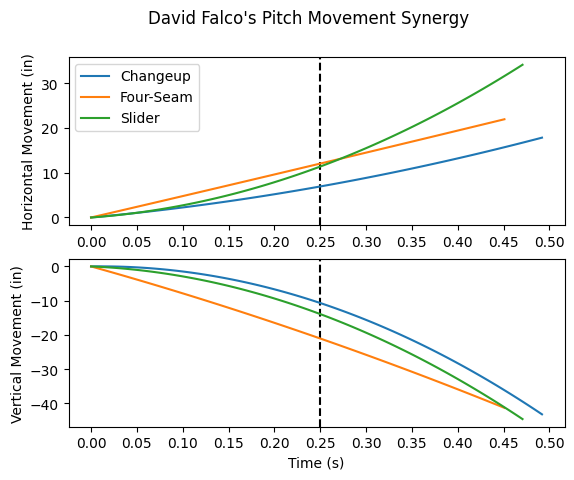

In [80]:
# create 2 subpluts, 1 for horizontal and 2 for vertical
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'{pitcher}\'s Pitch Movement Synergy')
ax1.set(ylabel= 'Horizontal Movement (in)', xticks= np.arange(0,0.6,0.05))
ax1.axvline(0.25, linestyle= '--', color= 'black')
ax2.set(ylabel= 'Vertical Movement (in)', xlabel= 'Time (s)', xticks= np.arange(0,0.6,0.05))
ax2.axvline(0.25, linestyle= '--', color= 'black')
for k in pitch_data:
    # 0, the time of 20ft 6in, time of 60ft 6in
    x_vals = [0, pitch_data[k][5], pitch_data[k][4]]
    
    # 0, total horz break at 20.5ft, total horz break at 60.5ft
    # y_vals = [0, abs(pitch_data[k][2])-abs(pitch_data[k][3]), abs(pitch_data[k][2])]
    y_vals = [0, pitch_data[k][3], pitch_data[k][2]]
    
    # Generate a spline interpolation function
    f = interp1d(x_vals, y_vals, kind='quadratic')
    pitch_data[k].append(f)

    # Evaluate the spline interpolation at 100 points between min(x_vals) and max(x_vals)
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y = f(x)
    ax1.plot(x, y, label= k)
    # ax1.plot(x_vals, y_vals)
    
    # 0, total vert break at 20.5ft, total vert break at 60.5ft
    # y_vals = [0, -abs(pitch_data[k][0]) + abs(pitch_data[k][1]), -abs(pitch_data[k][0])]
    y_vals = [0, pitch_data[k][1], pitch_data[k][0]]
    
    # Generate a spline interpolation function
    f = interp1d(x_vals, y_vals, kind='quadratic')
    pitch_data[k].append(f)

    # Evaluate the spline interpolation at 100 points between min(x_vals) and max(x_vals)
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y = f(x)
    ax2.plot(x, y, label= k)
    # ax2.plot(x_vals, y_vals)
    ax1.legend(loc='upper left')
plt.show()

In [81]:
# definig a function which takes in a pitch's plate location (in inches) and return what bucket the  pitch falls in.
# Assuming the center of the strike zone is at 0 side and 31 in height
def locToBucket(height, side):
    distToCenter = math.sqrt((height - 31)**2 + side**2)
    return int(distToCenter / 3) * 3    

In [87]:
# get rid of pitches that did not get their location recorded
df2 = df.dropna(subset= ['PlateLocHeight', 'PlateLocSide']).copy(deep= True)

# create a new column which has the location bucket of each pitch, which is the distance from the center of the strike zone
df2['locBucket'] = df2.apply(lambda row: locToBucket(12 * row.PlateLocHeight, 12 * row.PlateLocSide), axis= 1)

# create a swing indicator column
df2['swing?'] = df2['PitchCall'].apply(lambda x: x == 'StrikeSwinging' or x == 'InPlay' or x == 'Foul')

Now to create swing rate vs movement differential graphs I will use 0.2 seconds which is an arbituray time near the end of the information zone.

bucket: 3, swing rate: 1.0
bucket: 6, swing rate: 0.8333333333333334
bucket: 9, swing rate: 0.6666666666666666
bucket: 12, swing rate: 0.75
bucket: 15, swing rate: 0.375
bucket: 18, swing rate: 0.2857142857142857
bucket: 21, swing rate: 0.0
bucket: 24, swing rate: 0.0
bucket: 27, swing rate: 0.0
bucket: 30, swing rate: 0.0


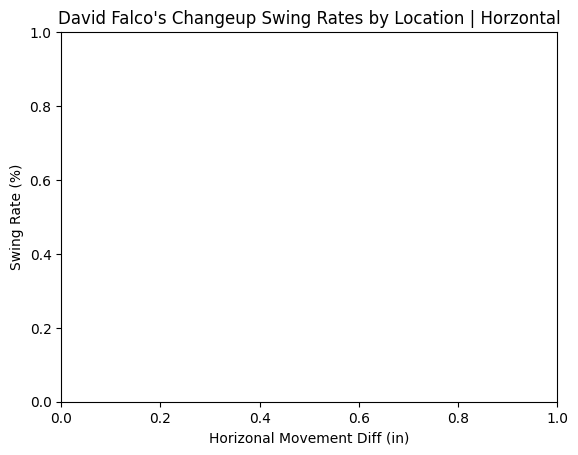

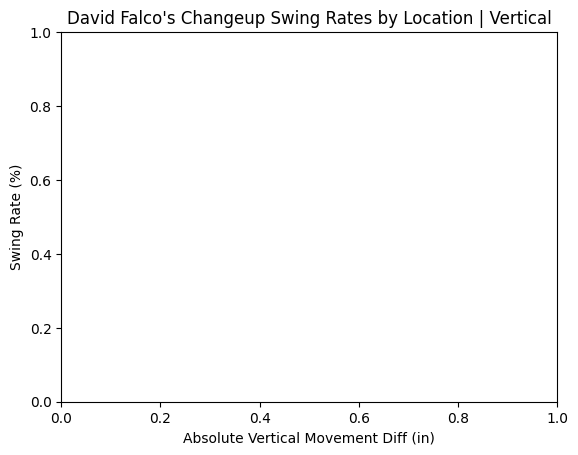

bucket: 0, swing rate: 1.0
bucket: 3, swing rate: 0.8333333333333334
bucket: 6, swing rate: 0.5714285714285714
bucket: 9, swing rate: 0.5555555555555556
bucket: 12, swing rate: 0.5714285714285714
bucket: 15, swing rate: 0.14285714285714285
bucket: 18, swing rate: 0.8
bucket: 21, swing rate: 0.3333333333333333
bucket: 24, swing rate: 0.0
bucket: 27, swing rate: 0.0
bucket: 30, swing rate: 0.0
bucket: 39, swing rate: 1.0
bucket: 42, swing rate: 0.0
bucket: 57, swing rate: 0.0


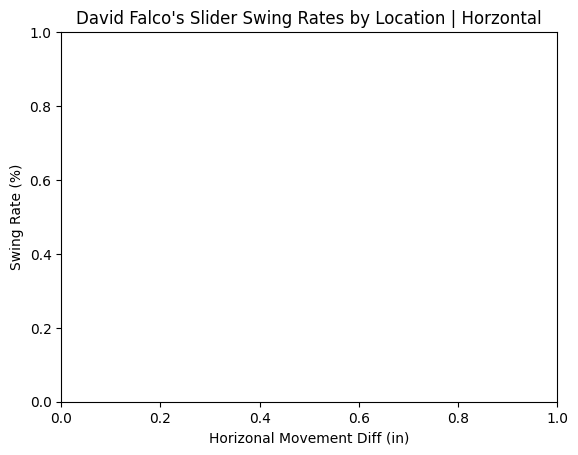

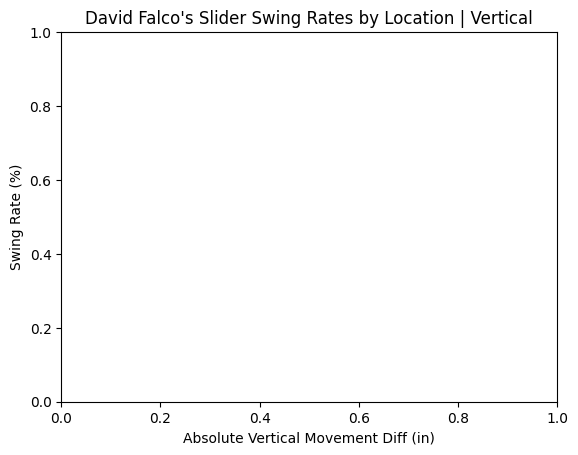

In [90]:
for k in pitch_data:
    if k != 'Four-Seam':
        # clear last pitch's graph
        plt.close()
        
        # set up next ptch horizonal break graph
        plt.title(f'{pitcher}\'s {k} Swing Rates by Location | Horzontal')
        plt.ylabel('Swing Rate (%)')
        plt.xlabel('Horizonal Movement Diff (in)')
        
        # baseline is the horz movement of four-seam
        pitch_df = df2.loc[df['TaggedPitchType'] == k]
        bucket_dfs = pitch_df.groupby('locBucket')
        for bucket in bucket_dfs:
            temp = bucket[1]['swing?'].mean()
            print(f'bucket: {bucket[0]}, swing rate: {temp}')
        
        plt.show()
        plt.close()
        
        # set up next ptch vertical break graph
        plt.title(f'{pitcher}\'s {k} Swing Rates by Location | Vertical')
        plt.ylabel('Swing Rate (%)')
        plt.xlabel('Absolute Vertical Movement Diff (in)')
        
        
        plt.show()


In [ ]:
pitch_data

{'Changeup': [-43.18103449200001,
  -1.0301494079999998,
  17.854461131999997,
  1.8726654720000013,
  0.49195139912467034,
  0.08538000411488306,
 'Four-Seam': [-41.293348094666655,
  -6.092406219428554,
  21.969931916,
  3.74169789752381,
  0.45096435184299327,
  0.0782665488593576,
 'Slider': [-44.571909549333334,
  -2.114052334666681,
  34.158111952,
  2.039731678666662,
  0.47072316996680275,
  0.08169576559848624,
  <scipy.interpolate._interpolate.interp1d at 0x7fb0b62a9f40>]}